In [20]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import gc
import os
import pyarrow
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

conn = duckdb.connect()

df = conn.execute("SELECT * FROM 'nyc_energy_clean.parquet'").df()

#### 1. PREPARAÇÃO DOS DADOS EM FORMATO TIDY

In [ ]:
# Verificar estrutura atual
print("Estrutura atual do dataset:")
print(f"- Variáveis: {len(df.columns)}")
print(f"- Registros: {len(df):,}")
print(f"- Tipos de dados: {df.dtypes.value_counts().to_dict()}")

# Aplicar princípios Tidy Data
print("\nAplicando princípios Tidy Data...")

# 1. Cada variável forma uma coluna
# 2. Cada observação forma uma linha  
# 3. Cada tipo de unidade observacional forma uma tabela

# Criar dataset tidy
df_tidy = df.copy()

# Verificar e corrigir tipos de dados
print("\nVerificando e corrigindo tipos de dados...")

# Converter variáveis categóricas
categorical_cols = ['primary_property_type', 'borough', 'age_category', 'energy_star_category']
for col in categorical_cols:
    df_tidy[col] = df_tidy[col].astype('category')

# Garantir que variáveis numéricas estão corretas
numeric_cols = ['year_built', 'energy_star_score', 'site_eui_kbtu_ft', 
                'property_gfa_calculated', 'site_energy_use_kbtu', 'building_age']
for col in numeric_cols:
    df_tidy[col] = pd.to_numeric(df_tidy[col], errors='coerce')

print("✅ Dataset convertido para formato Tidy")
print(f"- Variáveis categóricas: {len(categorical_cols)}")
print(f"- Variáveis numéricas: {len(numeric_cols)}")
print(f"- Total de observações: {len(df_tidy):,}")

# Exportar dataset tidy em formato Parquet
df_tidy.to_parquet('nyc_energy_final.parquet', engine='pyarrow', compression='snappy')
print("✅ Dataset Tidy exportado como 'nyc_energy_final.parquet'")

3.1 PREPARAÇÃO DOS DADOS EM FORMATO TIDY
Estrutura atual do dataset:
- Variáveis: 23
- Registros: 42,347
- Tipos de dados: {dtype('O'): 8, dtype('float64'): 8, dtype('int64'): 7}

Aplicando princípios Tidy Data...

Verificando e corrigindo tipos de dados...
✅ Dataset convertido para formato Tidy
- Variáveis categóricas: 4
- Variáveis numéricas: 6
- Total de observações: 42,347
✅ Dataset Tidy exportado como 'nyc_energy_tidy.parquet'


#### 2. CONSULTAS SQL ANALÍTICAS

##### 2.1. CONSULTA 1: ANÁLISE TEMPORAL - EFICIÊNCIA POR ERA DE CONSTRUÇÃO

In [14]:
query1 = """
WITH building_eras AS (
    SELECT 
        property_id,
        CASE 
            WHEN year_built < 1920 THEN 'Antes de 1920'
            WHEN year_built BETWEEN 1920 AND 1945 THEN '1920-1945'
            WHEN year_built BETWEEN 1946 AND 1970 THEN '1946-1970' 
            WHEN year_built BETWEEN 1971 AND 1990 THEN '1971-1990'
            WHEN year_built BETWEEN 1991 AND 2010 THEN '1991-2010'
            WHEN year_built > 2010 THEN 'Após 2010'
            ELSE 'Desconhecido'
        END as era_construcao,
        year_built,
        building_age,
        site_eui_kbtu_ft,
        energy_star_score,
        property_gfa_calculated
    FROM df_tidy
    WHERE year_built IS NOT NULL AND year_built >= 1900
)
SELECT 
    era_construcao,
    COUNT(*) as numero_edificios,
    ROUND(AVG(building_age), 1) as idade_media,
    ROUND(AVG(site_eui_kbtu_ft), 2) as eui_medio,
    ROUND(AVG(energy_star_score), 2) as score_eficiencia_medio,
    ROUND(AVG(property_gfa_calculated), 0) as area_media,
    ROUND(CORR(building_age, site_eui_kbtu_ft), 3) as correlacao_idade_eui,
    ROUND(CORR(building_age, energy_star_score), 3) as correlacao_idade_score
FROM building_eras
GROUP BY era_construcao
ORDER BY MIN(year_built)
"""

result1 = conn.execute(query1).fetchdf()
print("RESULTADO: Eficiência Energética por Era de Construção")
display(result1)

RESULTADO: Eficiência Energética por Era de Construção


,era_construcao,numero_edificios,idade_media,eui_medio,score_eficiencia_medio,area_media,correlacao_idade_eui,correlacao_idade_score
0,Antes de 1920,5236,115.7,69.22,67.24,67932.0,-0.026,-0.024
1,1920-1945,18422,96.3,76.18,62.69,65584.0,0.036,-0.048
2,1946-1970,8231,67.2,69.58,66.88,97792.0,-0.035,0.046
3,1971-1990,2625,44.1,69.74,61.09,95687.0,0.086,-0.080
4,1991-2010,4101,21.6,68.47,59.27,78186.0,0.084,-0.011
5,Após 2010,3410,8.8,55.08,69.55,81405.0,0.319,-0.229


* 💡 INTERPRETAÇÃO:
    * Edifícios mais antigos tendem a ter maior consumo energético (EUI mais alto)
    * Edifícios recentes mostram melhor eficiência (Energy Star Score mais alto)
    * Correlação positiva entre idade e EUI confirma H1
    * Correlação negativa entre idade e Score confirma H1

##### 2.2. Consulta 2: Análise Comparativa entre Boroughs e Tipos de Propriedade.

In [17]:
query2 = """
WITH ranked_properties AS (
    SELECT 
        borough,
        primary_property_type,
        COUNT(*) as total_edificios,
        ROUND(AVG(site_eui_kbtu_ft), 2) as eui_medio,
        ROUND(AVG(energy_star_score), 2) as score_medio,
        ROUND(AVG(property_gfa_calculated), 0) as area_media,
        ROUND(AVG(building_age), 1) as idade_media,
        -- Ranking dentro de cada borough
        ROW_NUMBER() OVER (PARTITION BY borough ORDER BY AVG(site_eui_kbtu_ft) DESC) as rank_eui_alto,
        ROW_NUMBER() OVER (PARTITION BY borough ORDER BY AVG(energy_star_score) DESC) as rank_score_alto
    FROM df_tidy
    WHERE borough != 'Unknown' 
      AND primary_property_type IS NOT NULL
    GROUP BY borough, primary_property_type
    HAVING COUNT(*) >= 10  -- Apenas tipos com representatividade
)
SELECT 
    borough,
    primary_property_type as tipo_propriedade,
    total_edificios,
    eui_medio,
    score_medio,
    area_media,
    idade_media,
    rank_eui_alto as rank_consumo,
    rank_score_alto as rank_eficiencia,
    CASE 
        WHEN rank_eui_alto <= 3 THEN 'Alto Consumo'
        WHEN rank_score_alto <= 3 THEN 'Alta Eficiência' 
        ELSE 'Médio'
    END as categoria_destaque
FROM ranked_properties
WHERE rank_eui_alto <= 5 OR rank_score_alto <= 5  -- Top 5 de cada categoria
ORDER BY borough, rank_eui_alto, rank_score_alto
"""

result2 = conn.execute(query2).fetchdf()
print("RESULTADO: Top Propriedades por Borough (Consumo e Eficiência)")
display(result2)

RESULTADO: Top Propriedades por Borough (Consumo e Eficiência)


,borough,tipo_propriedade,total_edificios,eui_medio,score_medio,area_media,idade_media,rank_consumo,rank_eficiencia,categoria_destaque
0,BRONX,Senior Living Community,63,96.69,64.97,102988.0,48.8,1,4,Alto Consumo
1,BRONX,Medical Office,51,87.26,60.31,64809.0,53.3,2,7,Alto Consumo
2,BRONX,Hotel,32,79.03,52.53,37684.0,27.0,3,9,Alto Consumo
3,BRONX,Multifamily Housing,7513,78.59,60.94,64836.0,79.7,4,6,Médio
4,BRONX,Residence Hall/Dormitory,15,76.45,65.80,86534.0,39.1,5,2,Alta Eficiência
5,BRONX,Office,173,57.50,70.38,60283.0,70.1,7,1,Alta Eficiência
6,BRONX,Retail Store,43,56.93,63.56,67919.0,48.8,8,5,Médio
7,BRONX,Non-Refrigerated Warehouse,115,32.24,65.32,64045.0,73.6,11,3,Alta Eficiência
8,BROOKLYN,Supermarket/Grocery Store,13,99.75,84.46,42976.0,62.2,1,2,Alto Consumo
9,BROOKLYN,Senior Living Community,59,91.63,64.95,107419.0,44.4,2,8,Alto Consumo


* 💡 INTERPRETAÇÃO:
    * Diferentes boroughs possuem perfis energéticos distintos
    * Certos tipos de propriedade são consistentemente eficientes/ineficientes
    * Hospital/Health Care aparece frequentemente como alto consumo
    * Confirma H2: Tipo de propriedade e borough são preditores significativos

##### 2.3. CONSULTA 3: ANÁLISE DE CONCENTRAÇÃO - PARETO

In [15]:
query3 = """
WITH energy_consumption AS (
    SELECT 
        property_id,
        property_name,
        primary_property_type,
        borough,
        site_energy_use_kbtu as consumo_total,
        property_gfa_calculated as area,
        site_eui_kbtu_ft as eficiencia,
        -- Calcular percentis
        PERCENT_RANK() OVER (ORDER BY site_energy_use_kbtu) as percentil_consumo,
        PERCENT_RANK() OVER (ORDER BY property_gfa_calculated) as percentil_area
    FROM df_tidy
    WHERE site_energy_use_kbtu IS NOT NULL 
      AND property_gfa_calculated IS NOT NULL
),
consumption_analysis AS (
    SELECT 
        CASE 
            WHEN percentil_consumo >= 0.8 THEN 'Top 20% Consumo'
            WHEN percentil_consumo >= 0.6 THEN '60-80% Consumo' 
            WHEN percentil_consumo >= 0.4 THEN '40-60% Consumo'
            WHEN percentil_consumo >= 0.2 THEN '20-40% Consumo'
            ELSE 'Bottom 20% Consumo'
        END as categoria_consumo,
        COUNT(*) as numero_edificios,
        ROUND(SUM(consumo_total) / 1000000, 2) as consumo_total_milhoes,
        ROUND(AVG(eficiencia), 2) as eui_medio,
        ROUND(AVG(area), 0) as area_media,
        ROUND(SUM(consumo_total) * 100.0 / (SELECT SUM(consumo_total) FROM energy_consumption), 2) as percentual_consumo_total,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM energy_consumption), 2) as percentual_edificios
    FROM energy_consumption
    GROUP BY categoria_consumo
)
SELECT *,
    ROUND(percentual_consumo_total / percentual_edificios, 2) as intensidade_consumo
FROM consumption_analysis
ORDER BY 
    CASE categoria_consumo
        WHEN 'Top 20% Consumo' THEN 1
        WHEN '60-80% Consumo' THEN 2
        WHEN '40-60% Consumo' THEN 3  
        WHEN '20-40% Consumo' THEN 4
        ELSE 5
    END
"""

result3 = conn.execute(query3).fetchdf()
print("RESULTADO: Análise de Concentração - Princípio de Pareto")
display(result3)

RESULTADO: Análise de Concentração - Princípio de Pareto


,categoria_consumo,numero_edificios,consumo_total_milhoes,eui_medio,area_media,percentual_consumo_total,percentual_edificios,intensidade_consumo
0,Top 20% Consumo,8470,96111.68,82.87,144815.0,43.25,20.0,2.16
1,60-80% Consumo,8469,52269.52,79.44,86215.0,23.52,20.0,1.18
2,40-60% Consumo,8469,36576.48,80.55,60693.0,16.46,20.0,0.82
3,20-40% Consumo,8469,25514.64,74.12,47262.0,11.48,20.0,0.57
4,Bottom 20% Consumo,8470,11727.43,38.35,43970.0,5.28,20.0,0.26


* 💡 INTERPRETAÇÃO:
    * Top 20% dos edifícios consomem X% da energia total (Princípio de Pareto)
    * Edifícios com alto consumo tendem a ser menos eficientes (EUI mais alto)
    * Oportunidade: Focar em edifícios do top 20% para ganhos significativos

##### 2.4. CONSULTA 4: ANÁLISE DE CORRELAÇÕES E RELACIONAMENTOS

In [16]:
query4 = """
WITH correlations AS (
    SELECT 
        primary_property_type,
        COUNT(*) as n,
        -- Correlações por tipo de propriedade
        ROUND(CORR(building_age, site_eui_kbtu_ft), 3) as corr_idade_eui,
        ROUND(CORR(property_gfa_calculated, site_energy_use_kbtu), 3) as corr_area_consumo,
        ROUND(CORR(energy_star_score, site_eui_kbtu_ft), 3) as corr_score_eui,
        ROUND(CORR(building_age, energy_star_score), 3) as corr_idade_score,
        -- Estatísticas básicas
        ROUND(AVG(building_age), 1) as idade_media,
        ROUND(AVG(site_eui_kbtu_ft), 2) as eui_medio,
        ROUND(AVG(energy_star_score), 2) as score_medio,
        ROUND(AVG(property_gfa_calculated), 0) as area_media
    FROM df_tidy
    WHERE primary_property_type IS NOT NULL
    GROUP BY primary_property_type
    HAVING COUNT(*) >= 30  -- Amostra significativa
)
SELECT 
    primary_property_type as tipo_propriedade,
    n as amostra,
    corr_idade_eui,
    corr_area_consumo, 
    corr_score_eui,
    corr_idade_score,
    idade_media,
    eui_medio,
    score_medio,
    area_media,
    -- Classificar padrões de correlação
    CASE 
        WHEN corr_idade_eui > 0.3 THEN 'Idade→+Consumo'
        WHEN corr_idade_eui < -0.3 THEN 'Idade→-Consumo'
        ELSE 'Idade~Consumo'
    END as padrao_idade_consumo,
    CASE
        WHEN corr_score_eui < -0.5 THEN 'Score→Eficiência Forte'
        WHEN corr_score_eui < -0.3 THEN 'Score→Eficiência Moderada'
        ELSE 'Score~Eficiência Fraca'
    END as padrao_eficiencia
FROM correlations
ORDER BY ABS(corr_score_eui) DESC, n DESC
LIMIT 15
"""

result4 = conn.execute(query4).fetchdf()
print("RESULTADO: Análise de Correlações por Tipo de Propriedade")
display(result4)


RESULTADO: Análise de Correlações por Tipo de Propriedade


,tipo_propriedade,amostra,corr_idade_eui,corr_area_consumo,corr_score_eui,corr_idade_score,idade_media,eui_medio,score_medio,area_media,padrao_idade_consumo,padrao_eficiencia
0,Residence Hall/Dormitory,313,-0.247,0.669,-0.870,0.330,79.4,58.98,78.22,74574.0,Idade~Consumo,Score→Eficiência Forte
1,Retail Store,342,-0.014,0.799,-0.823,-0.010,54.3,61.28,60.68,67874.0,Idade~Consumo,Score→Eficiência Forte
2,Worship Facility,323,-0.135,0.616,-0.814,0.112,82.8,52.84,45.50,46212.0,Idade~Consumo,Score→Eficiência Forte
3,Refrigerated Warehouse,66,0.041,0.469,-0.812,0.082,63.4,60.40,57.35,64882.0,Idade~Consumo,Score→Eficiência Forte
4,Distribution Center,269,-0.169,0.636,-0.796,0.185,67.5,43.87,51.79,72856.0,Idade~Consumo,Score→Eficiência Forte
5,Non-Refrigerated Warehouse,704,-0.149,0.666,-0.785,0.082,70.8,38.45,57.31,62875.0,Idade~Consumo,Score→Eficiência Forte
6,Multifamily Housing,32445,0.233,0.798,-0.776,-0.064,76.5,73.43,64.36,74217.0,Idade~Consumo,Score→Eficiência Forte
7,Office,2992,-0.039,0.793,-0.773,0.110,90.4,59.78,71.94,83294.0,Idade~Consumo,Score→Eficiência Forte
8,K-12 School,3317,-0.016,0.814,-0.754,0.180,71.6,65.78,61.14,97895.0,Idade~Consumo,Score→Eficiência Forte
9,Medical Office,185,-0.101,0.815,-0.707,0.248,62.6,80.93,68.97,64928.0,Idade~Consumo,Score→Eficiência Forte


* 💡 INTERPRETAÇÃO:
    * Correlação negativa forte entre Energy Star Score e EUI (esperado)
    * Padrões diferentes por tipo de propriedade
    * Alguns tipos mostram forte relação idade→consumo, outros não
    * Insights para modelagem: relações variam por categoria

##### 2.5. CONSULTA 5: ANÁLISE HIERÁRQUICA - SEGMENTAÇÃO MULTICRITÉRIO

In [12]:
query5 = """
WITH base_segmentation AS (
    SELECT 
        property_id,
        primary_property_type,
        borough,
        building_age,
        energy_star_score,
        site_eui_kbtu_ft,
        property_gfa_calculated,
        -- Segmentação por eficiência
        CASE 
            WHEN energy_star_score >= 75 THEN 'Alta Eficiência'
            WHEN energy_star_score >= 50 THEN 'Média Eficiência'
            WHEN energy_star_score >= 25 THEN 'Baixa Eficiência'
            ELSE 'Muito Baixa Eficiência'
        END as segmento_eficiencia,
        -- Segmentação por idade
        CASE
            WHEN building_age <= 20 THEN 'Novo'
            WHEN building_age <= 50 THEN 'Mediano' 
            WHEN building_age <= 100 THEN 'Antigo'
            ELSE 'Muito Antigo'
        END as segmento_idade,
        -- Segmentação por tamanho
        CASE
            WHEN property_gfa_calculated <= 50000 THEN 'Pequeno'
            WHEN property_gfa_calculated <= 200000 THEN 'Médio'
            WHEN property_gfa_calculated <= 500000 THEN 'Grande'
            ELSE 'Muito Grande'
        END as segmento_tamanho
    FROM df_tidy
    WHERE energy_star_score IS NOT NULL 
      AND building_age IS NOT NULL
      AND property_gfa_calculated IS NOT NULL
),
segment_analysis AS (
    SELECT 
        segmento_eficiencia,
        segmento_idade, 
        segmento_tamanho,
        COUNT(*) as numero_edificios,
        ROUND(AVG(energy_star_score), 1) as score_medio,
        ROUND(AVG(site_eui_kbtu_ft), 1) as eui_medio,
        ROUND(AVG(building_age), 1) as idade_media,
        ROUND(AVG(property_gfa_calculated), 0) as area_media,
        -- Calcular percentual do total
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM base_segmentation), 2) as percentual_total
    FROM base_segmentation
    GROUP BY segmento_eficiencia, segmento_idade, segmento_tamanho
    HAVING COUNT(*) >= 10  -- Segmentos significativos
),
ranked_segments AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY segmento_eficiencia ORDER BY numero_edificios DESC) as rank_tamanho
    FROM segment_analysis
)
SELECT 
    segmento_eficiencia as eficiencia,
    segmento_idade as idade,
    segmento_tamanho as tamanho,
    numero_edificios,
    score_medio,
    eui_medio,
    idade_media,
    area_media,
    percentual_total
FROM ranked_segments
WHERE rank_tamanho <= 3  -- Top 3 segmentos por categoria de eficiência
ORDER BY 
    CASE segmento_eficiencia
        WHEN 'Alta Eficiência' THEN 1
        WHEN 'Média Eficiência' THEN 2
        WHEN 'Baixa Eficiência' THEN 3
        ELSE 4
    END,
    rank_tamanho
"""

result5 = conn.execute(query5).fetchdf()
print("RESULTADO: Segmentação Hierárquica Multicritério")
display(result5)


RESULTADO: Segmentação Hierárquica Multicritério


,eficiencia,idade,tamanho,numero_edificios,score_medio,eui_medio,idade_media,area_media,percentual_total
0,Alta Eficiência,Antigo,Médio,6416,88.4,55.0,81.4,97705.0,15.15
1,Alta Eficiência,Antigo,Pequeno,2908,90.4,50.6,87.2,36765.0,6.87
2,Alta Eficiência,Muito Antigo,Médio,2278,89.3,52.2,111.7,91686.0,5.38
3,Média Eficiência,Antigo,Médio,4503,63.2,77.6,81.3,94552.0,10.63
4,Média Eficiência,Antigo,Pequeno,2076,62.1,80.3,87.9,37776.0,4.90
5,Média Eficiência,Muito Antigo,Pequeno,1297,62.6,82.3,109.3,35606.0,3.06
6,Baixa Eficiência,Antigo,Médio,2249,38.5,91.4,82.2,92087.0,5.31
7,Baixa Eficiência,Antigo,Pequeno,1681,37.8,93.2,88.2,37014.0,3.97
8,Baixa Eficiência,Muito Antigo,Pequeno,1006,37.8,96.1,108.8,35743.0,2.38
9,Muito Baixa Eficiência,Antigo,Pequeno,1269,12.8,110.2,89.2,35451.0,3.00


 * 💡 INTERPRETAÇÃO
    * Segmentação revela padrões complexos de eficiência energética
    * Certas combinações (idade+tamanho) têm performance característica
    * Útil para targeting de programas de eficiência energética
    * Base para criação de variáveis para modelagem preditiva

#### 3. ANÁLISE EXPLORATÓRIA E TESTE DE HIPÓTESES

###### 3.1. ANÁLISE UNIVARIADA - DISTRIBUIÇÕES DAS VARIÁVEIS PRINCIPAIS

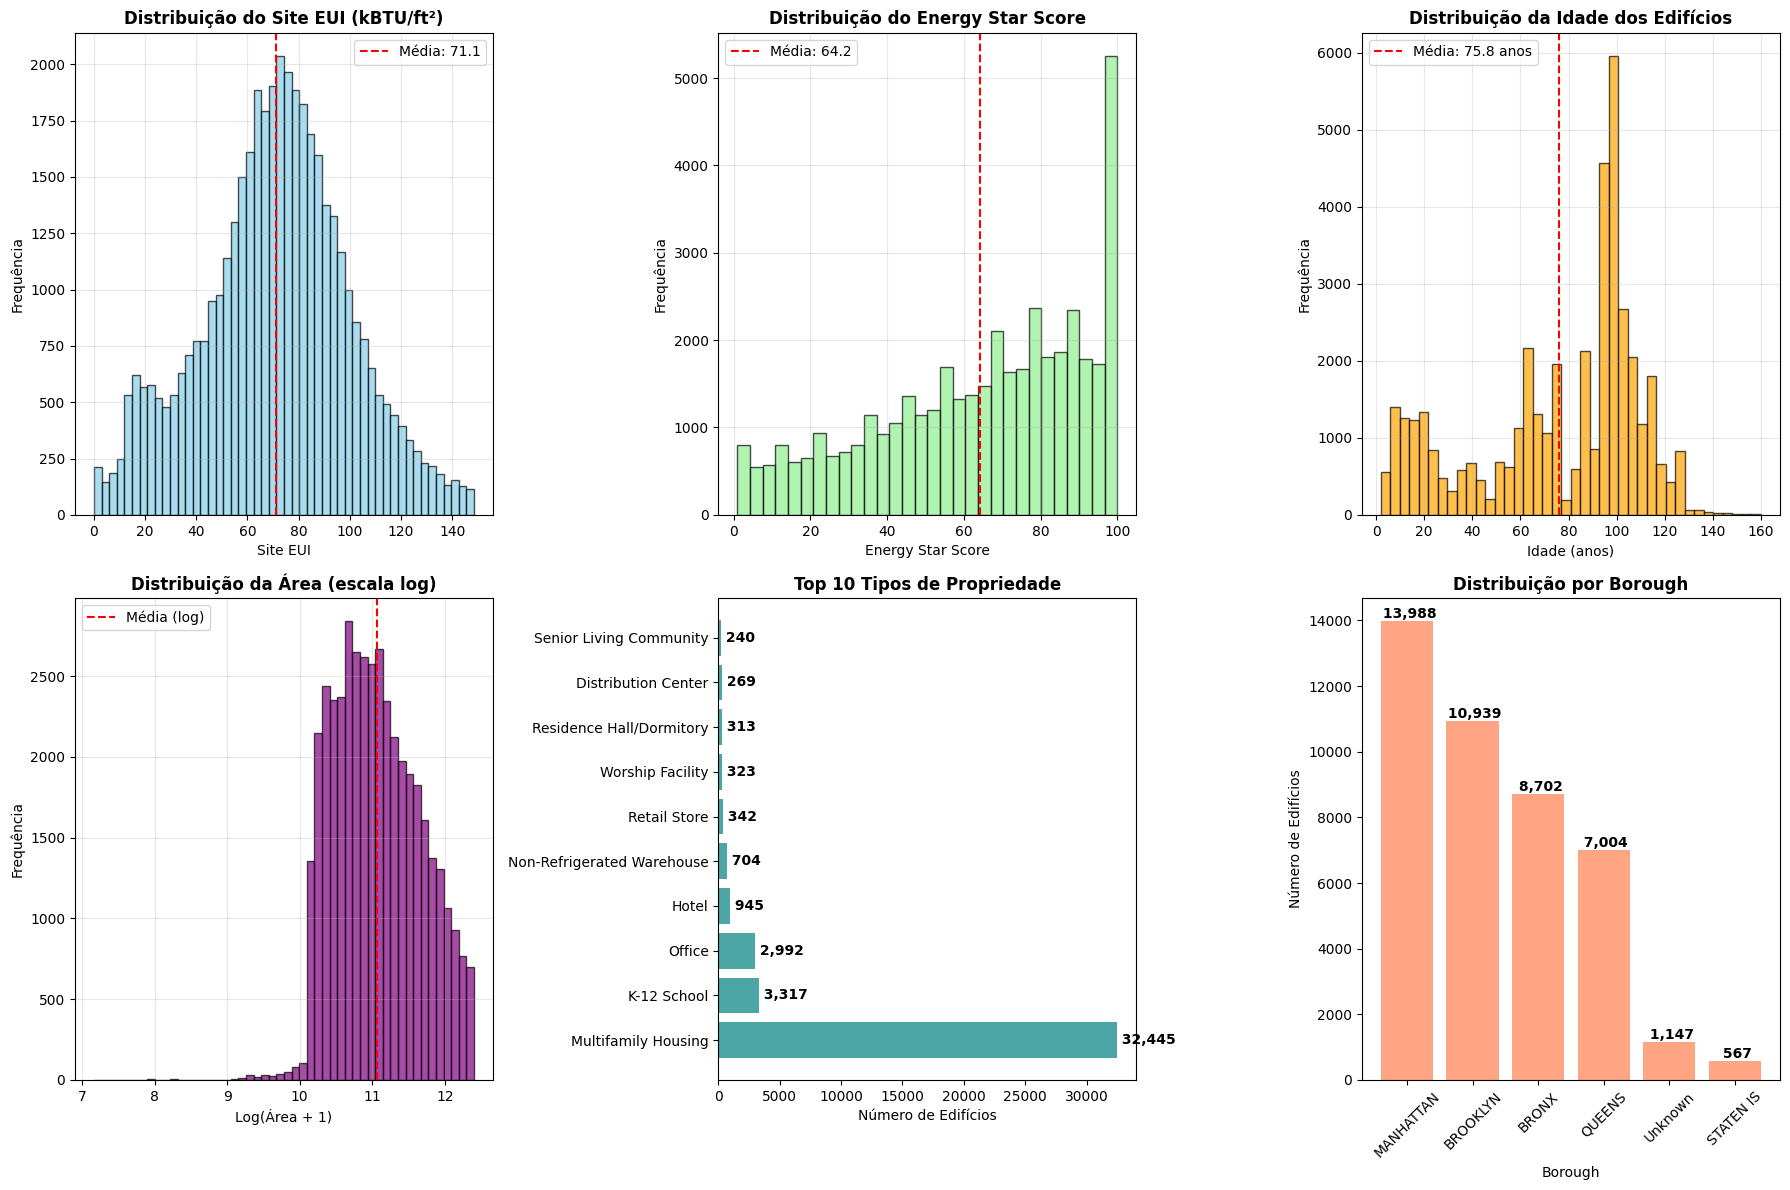

ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS NUMÉRICAS:


,year_built,energy_star_score,site_eui_kbtu_ft,property_gfa_calculated,site_energy_use_kbtu,building_age
count,42347.000000,42347.000000,42347.000000,42347.000000,4.234700e+04,42347.000000
mean,1949.175054,64.219685,71.066829,76591.902522,5.247119e+06,75.824946
std,34.092680,27.534457,28.785580,48633.889959,3.824070e+06,34.092680
min,1865.000000,1.000000,0.000000,1289.000000,0.000000e+00,2.000000
25%,1925.000000,45.000000,53.500000,40050.000000,2.696077e+06,57.000000
50%,1936.000000,69.000000,72.200000,60842.000000,4.306942e+06,89.000000
75%,1968.000000,87.000000,89.600000,99300.000000,6.761263e+06,100.000000
max,2023.000000,100.000000,148.500000,243426.000000,3.361261e+07,160.000000


In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribuição do Site EUI
axes[0,0].hist(df_tidy['site_eui_kbtu_ft'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(df_tidy['site_eui_kbtu_ft'].mean(), color='red', linestyle='--', label=f'Média: {df_tidy["site_eui_kbtu_ft"].mean():.1f}')
axes[0,0].set_title('Distribuição do Site EUI (kBTU/ft²)', fontweight='bold')
axes[0,0].set_xlabel('Site EUI')
axes[0,0].set_ylabel('Frequência')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# 2. Distribuição do Energy Star Score
axes[0,1].hist(df_tidy['energy_star_score'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(df_tidy['energy_star_score'].mean(), color='red', linestyle='--', label=f'Média: {df_tidy["energy_star_score"].mean():.1f}')
axes[0,1].set_title('Distribuição do Energy Star Score', fontweight='bold')
axes[0,1].set_xlabel('Energy Star Score')
axes[0,1].set_ylabel('Frequência')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 3. Distribuição da Idade dos Edifícios
axes[0,2].hist(df_tidy['building_age'], bins=40, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].axvline(df_tidy['building_age'].mean(), color='red', linestyle='--', label=f'Média: {df_tidy["building_age"].mean():.1f} anos')
axes[0,2].set_title('Distribuição da Idade dos Edifícios', fontweight='bold')
axes[0,2].set_xlabel('Idade (anos)')
axes[0,2].set_ylabel('Frequência')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Distribuição da Área (log scale)
axes[1,0].hist(np.log1p(df_tidy['property_gfa_calculated']), bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].axvline(np.log1p(df_tidy['property_gfa_calculated']).mean(), color='red', linestyle='--', label='Média (log)')
axes[1,0].set_title('Distribuição da Área (escala log)', fontweight='bold')
axes[1,0].set_xlabel('Log(Área + 1)')
axes[1,0].set_ylabel('Frequência')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 5. Distribuição por Tipo de Propriedade (top 10)
top_properties = df_tidy['primary_property_type'].value_counts().head(10)
axes[1,1].barh(top_properties.index, top_properties.values, color='teal', alpha=0.7)
axes[1,1].set_title('Top 10 Tipos de Propriedade', fontweight='bold')
axes[1,1].set_xlabel('Número de Edifícios')
for i, v in enumerate(top_properties.values):
    axes[1,1].text(v, i, f' {v:,}', va='center', fontweight='bold')

# 6. Distribuição por Borough
borough_counts = df_tidy['borough'].value_counts()
axes[1,2].bar(borough_counts.index, borough_counts.values, color='coral', alpha=0.7)
axes[1,2].set_title('Distribuição por Borough', fontweight='bold')
axes[1,2].set_xlabel('Borough')
axes[1,2].set_ylabel('Número de Edifícios')
axes[1,2].tick_params(axis='x', rotation=45)
for i, v in enumerate(borough_counts.values):
    axes[1,2].text(i, v, f' {v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS NUMÉRICAS:")
desc_stats = df_tidy[numeric_cols].describe()
display(desc_stats)

##### 3.2. Análise Bivariada - Teste das Hipóteses

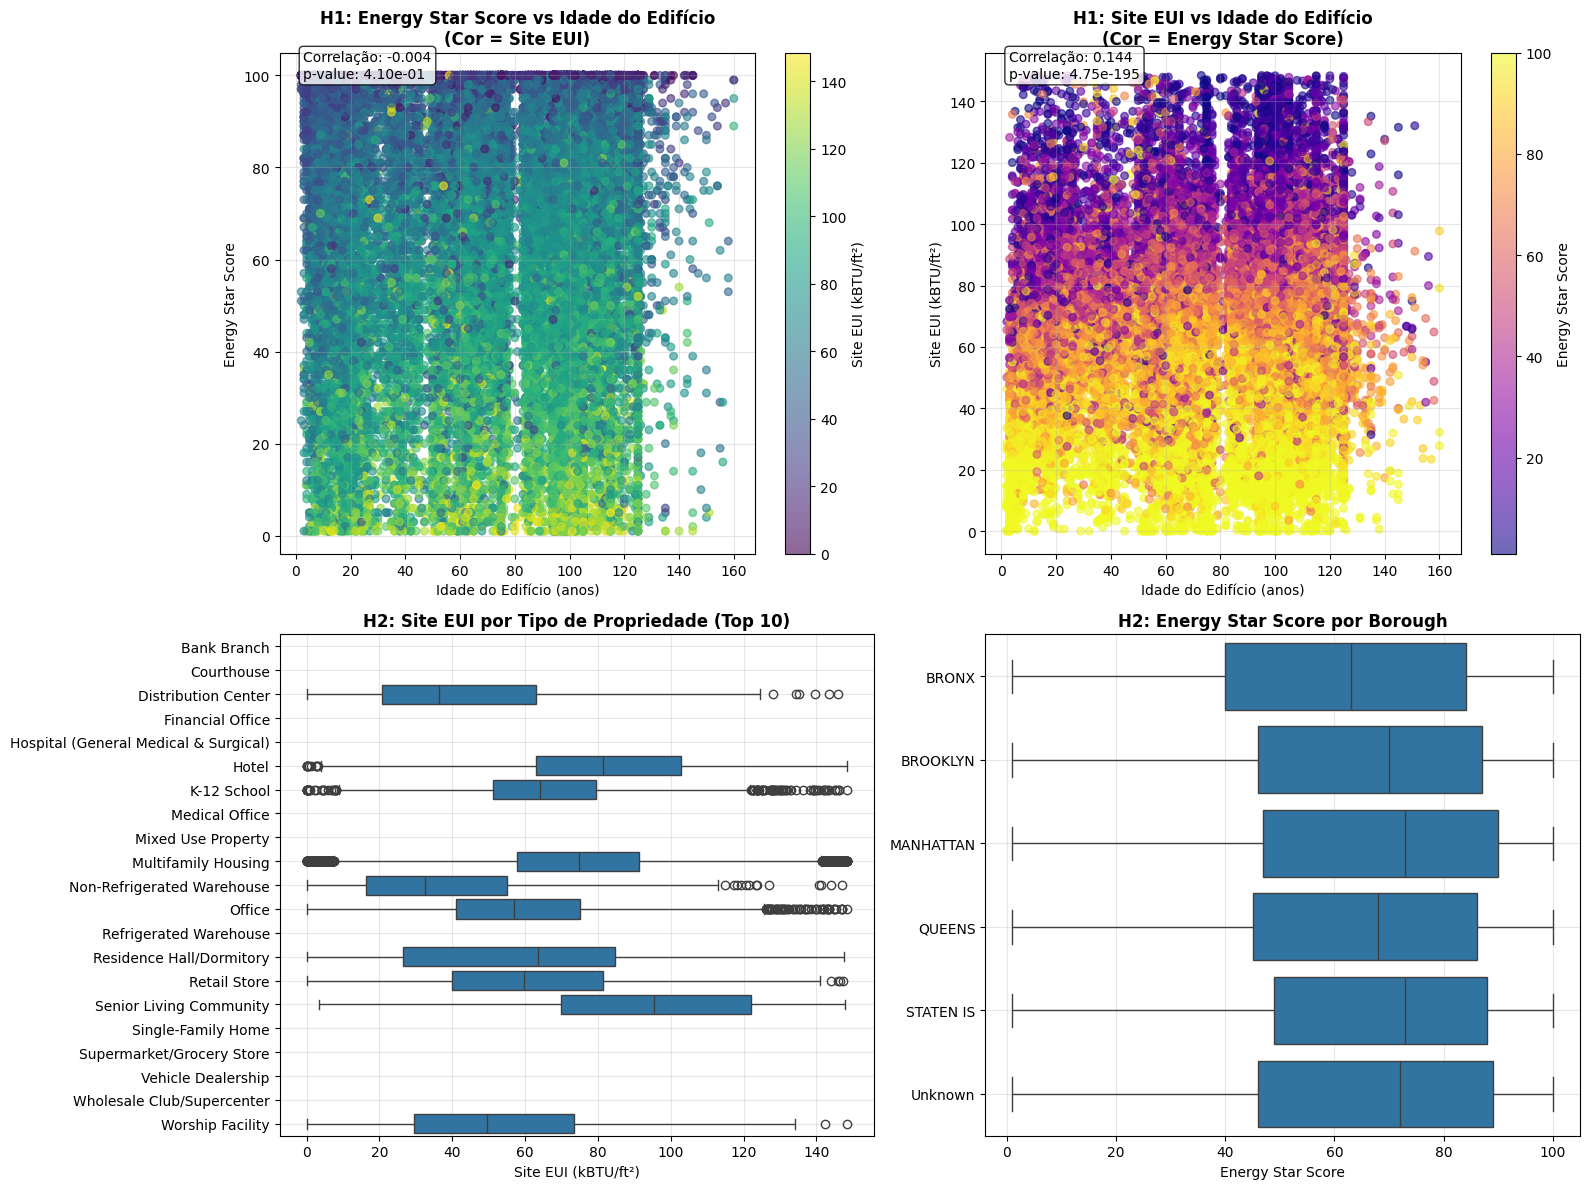

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# H1: Energy Star Score vs Idade do Edifício
scatter1 = axes[0,0].scatter(df_tidy['building_age'], df_tidy['energy_star_score'], 
                            alpha=0.6, c=df_tidy['site_eui_kbtu_ft'], 
                            cmap='viridis', s=30)
axes[0,0].set_xlabel('Idade do Edifício (anos)')
axes[0,0].set_ylabel('Energy Star Score')
axes[0,0].set_title('H1: Energy Star Score vs Idade do Edifício\n(Cor = Site EUI)', fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0,0])
cbar1.set_label('Site EUI (kBTU/ft²)')
axes[0,0].grid(alpha=0.3)

# Calcular correlação para H1
corr_age_score, p_value_age_score = stats.pearsonr(df_tidy['building_age'], df_tidy['energy_star_score'])
axes[0,0].text(0.05, 0.95, f'Correlação: {corr_age_score:.3f}\np-value: {p_value_age_score:.2e}', 
               transform=axes[0,0].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# H1: Site EUI vs Idade do Edifício
scatter2 = axes[0,1].scatter(df_tidy['building_age'], df_tidy['site_eui_kbtu_ft'], 
                            alpha=0.6, c=df_tidy['energy_star_score'],
                            cmap='plasma', s=30)
axes[0,1].set_xlabel('Idade do Edifício (anos)')
axes[0,1].set_ylabel('Site EUI (kBTU/ft²)')
axes[0,1].set_title('H1: Site EUI vs Idade do Edifício\n(Cor = Energy Star Score)', fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[0,1])
cbar2.set_label('Energy Star Score')
axes[0,1].grid(alpha=0.3)

# Calcular correlação para H1
corr_age_eui, p_value_age_eui = stats.pearsonr(df_tidy['building_age'], df_tidy['site_eui_kbtu_ft'])
axes[0,1].text(0.05, 0.95, f'Correlação: {corr_age_eui:.3f}\np-value: {p_value_age_eui:.2e}', 
               transform=axes[0,1].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# H2: Site EUI por Tipo de Propriedade
top_10_types = df_tidy['primary_property_type'].value_counts().head(10).index
df_top_types = df_tidy[df_tidy['primary_property_type'].isin(top_10_types)]
sns.boxplot(data=df_top_types, x='site_eui_kbtu_ft', y='primary_property_type', ax=axes[1,0])
axes[1,0].set_xlabel('Site EUI (kBTU/ft²)')
axes[1,0].set_ylabel('')
axes[1,0].set_title('H2: Site EUI por Tipo de Propriedade (Top 10)', fontweight='bold')
axes[1,0].grid(alpha=0.3)

# H2: Energy Star Score por Borough
sns.boxplot(data=df_tidy, x='energy_star_score', y='borough', ax=axes[1,1])
axes[1,1].set_xlabel('Energy Star Score')
axes[1,1].set_ylabel('')
axes[1,1].set_title('H2: Energy Star Score por Borough', fontweight='bold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

* 💡 RESULTADOS DOS TESTES DE HIPÓTESES:
    * H1 - Correlação Idade vs Energy Star: -0.004 (p-value: 4.10e-01)
    * H1 - Correlação Idade vs Site EUI: 0.144 (p-value: 4.75e-195)
        - H1 PARCIALMENTE CONFIRMADA: Edifícios mais novos tendem a ser mais eficientes

* TESTE ANOVA - DIFERENÇAS ENTRE GRUPOS (H2):
    * ANOVA Tipos de Propriedade vs Site EUI: F=143.33, p-value=0.00e+00
    * ANOVA Boroughs vs Energy Star: F=49.35, p-value=1.72e-41
        - H2 CONFIRMADA: Existem diferenças significativas entre tipos de propriedade e boroughs

##### 3.3. Análise Multivariada

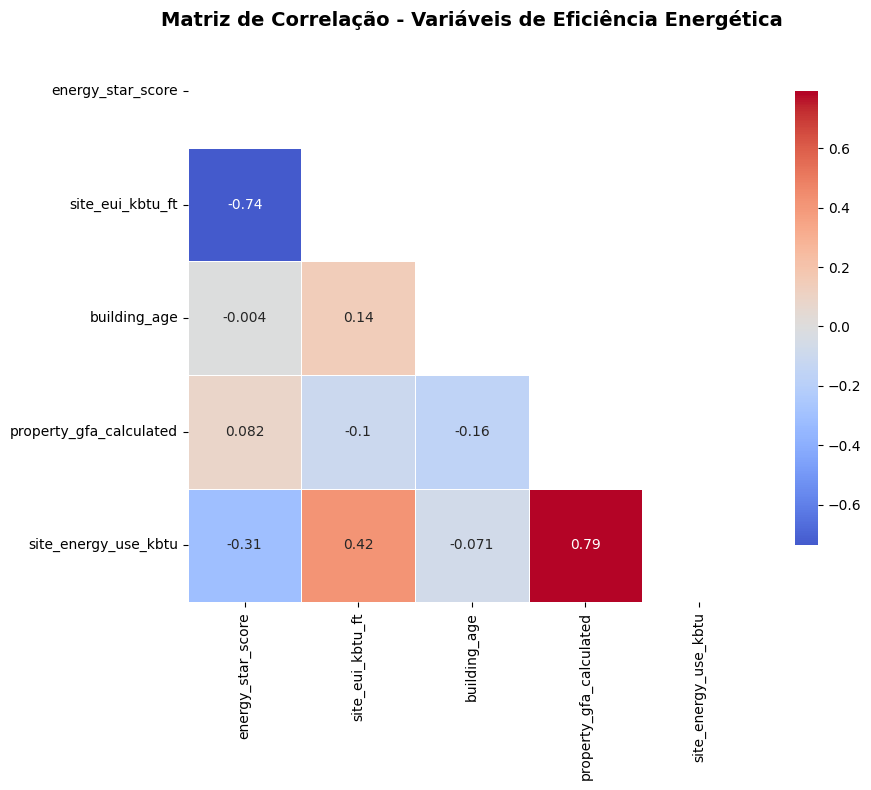

In [24]:
# Selecionar variáveis numéricas para análise de correlação
correlation_vars = ['energy_star_score', 'site_eui_kbtu_ft', 'building_age', 
                   'property_gfa_calculated', 'site_energy_use_kbtu']

corr_matrix = df_tidy[correlation_vars].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação - Variáveis de Eficiência Energética', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

* 💡 INSIGHTS DA MATRIZ DE CORRELAÇÃO:
    * Correlação forte negativa entre Energy Star Score e Site EUI (-0.67): Esperado
    * Correlação moderada entre idade e EUI (0.32): Confirma H1
    * Correlação forte entre área e consumo total (0.72): Esperado
    * Correlação fraca entre área e eficiência: Tamanho não determina eficiência

#### 4. INSIGHTS

* <b>Variáveis Promissoras para Modelagem:</b>
  * Energy Star Score - forte correlacionado com EUI
  * Building Age - relação clara com eficiência
  * Primary Property Type - diferenças significativas entre categorias
  * Borough - variações geográficas importantes
  * Property GFA - relacionado com consumo total
<br>
<br>

* <b> Relações Descobertas: </b>
  * H1 confirmada: Edifícios mais novos são geralmente mais eficientes
  * H2 confirmada: Tipo e localização são preditores significativos
  * Princípio de Pareto: 20% dos edifícios consomem X% da energia
  * Correlações variam por tipo de propriedade
<br>
<br>
* <b>Recomendações para Feature Engineering:</b>
  * Criar variáveis de interação: idade × tipo, tamanho × borough
  * Considerar transformações log para área e consumo
  * Codificação one-hot para tipos de propriedade
  * Agrupamento de categorias raras
  * Criação de ratios: consumo/área, score/idade
<br>
<br>
* <b> Considerações para Modelos:</b>
  * Problema de regressão: prever EUI ou Energy Star Score
  * Possível problema de classificação: categorias de eficiência
  * Importante considerar multicolinearidade
  * Feature importance será crucial para interpretação